In [67]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [68]:
import numpy as np
import pandas as pd

In [69]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [70]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [71]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [72]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [73]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [74]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [75]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [76]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [77]:
# Column Names
mcolumns = inspector.get_columns('Measurement')
for c in mcolumns:
    print(c['name'], c["type"])

scolumns = inspector.get_columns('Station')
for c in scolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

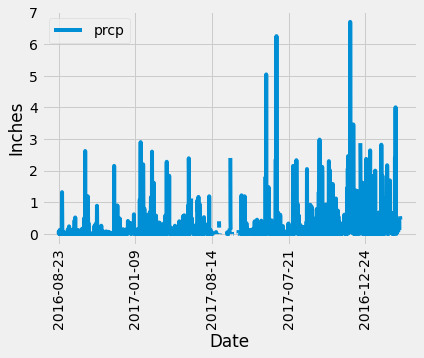

In [78]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_dt = dt.date(2017, 8, 23)
year_ago = latest_date_dt - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago)
precip_df = pd.DataFrame(precip)
precip_df
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df.set_index("date", inplace=True)
# Sort the dataframe by date
precip_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig('Images/Precipitation')
plt.show()

In [79]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_sum_df = precip_df.describe()
precip_sum_df


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [80]:
# Design a query to show how many stations are available in this dataset?
stats_query = session.query(Station.station).count()
print(f"There are {stats_query} total stations")

There are 9 total stations


In [81]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [82]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stat = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs),\
                          func.avg(Measurement.tobs)).\
                          filter(Measurement.station == "USC00519281").all()

temp_stat

[(85.0, 54.0, 71.66378066378067)]

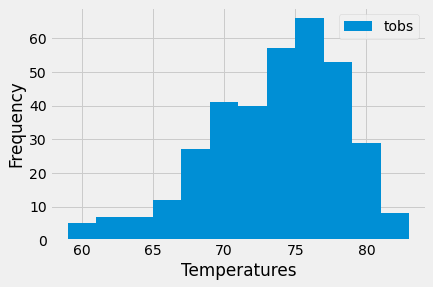

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_tobs = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
           filter(Measurement.date >= year_ago).all()

max_tobs_df = pd.DataFrame(max_tobs)
max_tobs_df.plot.hist(bins=12)
plt.xlabel("Temperatures")
plt.savefig('Images/station-histogram')
plt.show()

## Bonus Challenge Assignment

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [91]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 8, 23)
end_date = dt.date(2017,9, 7)

trip = calc_temps(start_date, end_date)[0]
print(f'Start of Vacation: {start_date}.')
print(f'End of Vacation: {end_date}.')
print(f'Coldest Temp of Vacation: {trip[0]}\n'
      f'Average Temp of Vacation: {trip[1]}\n'
      f'Warmest Temp of Vacation: {trip[2]}')

Start of Vacation: 2017-08-23.
End of Vacation: 2017-09-07.
Coldest Temp of Vacation: 76.0
Average Temp of Vacation: 80.25
Warmest Temp of Vacation: 82.0


In [136]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
figsize=(4,6)
plt.bar(x=1, height=80.2, width=0.25, yerr=(trip[2]-trip[0]), color='coral', alpha=0.5)
plt.xticks(np.arange(1, 1.0))
plt.xlim(0, 2)
plt.ylim(0, 100)
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.ylabel('Temp (F)')
plt.savefig('Images/tripavgtemp.png')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'plt'

In [116]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

p_start_date = start_date - dt.timedelta(days=365)
p_end_date = end_date - dt.timedelta(days=365)

tot_rainfall = 
p_precip = session.query(*tot_rainfall)\
                    .groupby(Measurement.station)\
                    .filter(Measurement.station == Station.station)\
                    .filter(Measurement.date >= p_start_date) & (Measurement.date <= p_end_date)\
                    .order_by(desc()).all()
p_precip
p_precip_df = pd.DataFrame(p_precip)
p_precip_df


# active = session.query(Measurement.station, func.count(Measurement.station)).\
#                         group_by(Measurement.station).\
#                         order_by(func.count(Measurement.station).desc()).all()

SyntaxError: invalid syntax (<ipython-input-116-0ca635499d2c>, line 7)

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
